# TEXT CLASSIFICATION USING BERT

# Import the necessary libraries

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Load the data

In [2]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
747/4825

0.15481865284974095

# 15% spam emails, 85% ham emails: This indicates class imbalance

In [6]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [10]:
df_balanced['Category'].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [11]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
4186,ham,I'm good. Have you registered to vote?,0
4860,ham,"Hey, a guy I know is breathing down my neck to...",0
1252,spam,Please CALL 08712402779 immediately as there i...,1
4594,ham,It's ok i wun b angry. Msg u aft i come home t...,0
3388,ham,So u workin overtime nigpun?,0


# Split it into training and test data set

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

# Now lets import BERT model and get embeding vectors for few sample statements

In [13]:
X_train.head(4)

4991    Phony £350 award - Todays Voda numbers ending ...
5566    REMINDER FROM O2: To get 2.50 pounds free call...
3334    You are being contacted by our dating service ...
5141    FREE for 1st week! No1 Nokia tone 4 ur mobile ...
Name: Message, dtype: object

In [14]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [15]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132726 , -0.8884572 , ..., -0.74748856,
        -0.75314724,  0.91964495],
       [-0.8720835 , -0.50543964, -0.94446677, ..., -0.8584752 ,
        -0.7174535 ,  0.8808299 ]], dtype=float32)>

In [16]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])


array([[0.9911089]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

# Build Model
There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [18]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703845]], dtype=float32)

In [19]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872036]], dtype=float32)

In [20]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [22]:
len(X_train)

1120

In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

# Train the model

In [24]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 330s 9s/step - loss: 0.6736 - accuracy: 0.5670 - precision: 0.5740 - recall: 0.5196
Epoch 2/10
35/35 [==============================] - 367s 10s/step - loss: 0.5635 - accuracy: 0.7491 - precision: 0.7345 - recall: 0.7804
Epoch 3/10
35/35 [==============================] - 364s 10s/step - loss: 0.4913 - accuracy: 0.8045 - precision: 0.8028 - recall: 0.8071
Epoch 4/10
35/35 [==============================] - 429s 12s/step - loss: 0.4435 - accuracy: 0.8223 - precision: 0.8085 - recall: 0.8446
Epoch 5/10
35/35 [==============================] - 395s 11s/step - loss: 0.3908 - accuracy: 0.8723 - precision: 0.8677 - recall: 0.8786
Epoch 6/10
35/35 [==============================] - 380s 11s/step - loss: 0.3685 - accuracy: 0.8687 - precision: 0.8591 - recall: 0.8821
Epoch 7/10
35/35 [==============================] - 397s 11s/step - loss: 0.3522 - accuracy: 0.8768 - precision: 0.8601 - recall: 0.9000
Epoch 8/10
35/35 [========================

In [25]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 137s 11s/step - loss: 0.2941 - accuracy: 0.9091 - precision: 0.8964 - recall: 0.9251


[0.29408493638038635,
 0.9090909361839294,
 0.8963730335235596,
 0.9251337051391602]

In [26]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 125s 10s/step


In [28]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[167,  20],
       [ 14, 173]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

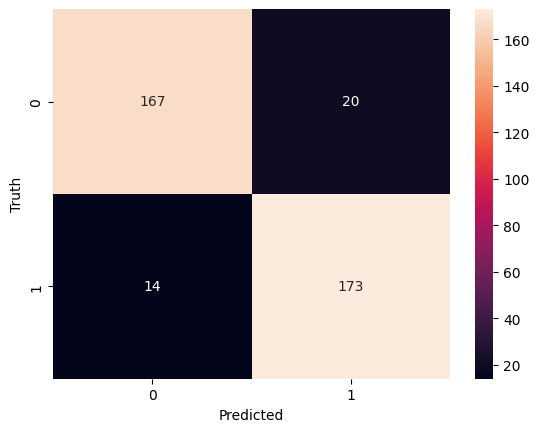

In [30]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [31]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       187
           1       0.90      0.93      0.91       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374



# Inference

In [32]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.7442588 ],
       [0.8084942 ],
       [0.77856636],
       [0.21618257],
       [0.12779802]], dtype=float32)